# Tutorial: Auditory Stimuli Inputs using FilterNet

* Allows users to use audio wav files as stimuli for virtual neurons with filters that detect spectral and temporal modulation

* Users need to install pycochleagram to run this
https://github.com/mcdermottLab/pycochleagram
https://readthedocs.org/projects/pycochleagram/

In the first part of the tutorial, we will make a simple auditory filter virtual neuron. For convenience, we will clone it five times to simulate 5 trials for the creation of a peristimulus time histogram.


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from bmtk.builder import NetworkBuilder
import shutil
import os

# Clear existing outputs and network files if rerunning
if os.path.exists('./sim_aud/output'):
    shutil.rmtree('./sim_aud/output')
if os.path.exists('./sim_aud/network'):
    shutil.rmtree('./sim_aud/network')
    
# Add a single node and plot its properties and response to the sound   

net = NetworkBuilder('aud')  # Initialize network called 'aud'

net.add_nodes(
    N = 5,
    model_type='virtual',
    model_template='audmodel:AUD_filt',
    y = 4,      # log2(center frequency/50 Hz)
    t_mod_freq = 5.0,
    sp_mod_freq = 0.0,
    delay = 5,      # ms
    dynamics_params='AUD_filt_partial.json',
    plot_filt = True
)

# Create and save the network
net.build()
net.save_nodes(output_dir='sim_aud/network')

from bmtk.utils.sim_setup import build_env_filternet

build_env_filternet(
    base_dir='sim_aud', 
    network_dir='sim_aud/network', 
    tstop=3000.0,                   # run the simulation for 3 seconds 
    include_examples=True)          # includes example model files which we'll use in this tutorial
    
from bmtk.simulator import filternet

config = filternet.Config.from_json('sim_aud/config.json')
config.build_env()
net = filternet.FilterNetwork.from_config(config)
sim = filternet.FilterSimulator.from_config(config, net)
sim.run()

In [ ]:
from bmtk.analyzer.spike_trains import plot_raster
from scipy import signal
from scipy.io import wavfile

fig, ax0 = plt.subplots(1, 1, figsize = (6,4.5),sharex=True)

sample_rate, samples = wavfile.read('sim_aud/audio/sa1.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

ax0.pcolormesh(times*1000, frequencies/1000, np.log(spectrogram))
ax0.set_ylabel('Frequency [kHz]')
ax0.set_xlabel('Time [ms]')
ax0.set_xlim((0,3000))

figr = plot_raster(config_file='sim_aud/config.json', group_by='model_template')
figr.set_figwidth(6)

Let's take a look in the simulation_config.json file, where the stimulus is controlled:

```json
"inputs": {
  "movie": {
      "input_type": "audio",
      "module": "wav_file",
      "data_file": "$BASE_DIR/audio/sa1.wav",
      "normalize": "full",
      "interp_to_freq": true,
      "padding": "edge"
   }
}
``` 

To change the stimulus to a WAV file of your choice, point to the relative path of the file under "data_file". 

The filter carrier consists of a sinusoidal modulation in 2D akin to a plane wave. This carrier is multiplied by a Gaussian envelope in the spectral axis and an asymmetric scaled gamma distribution function in the temporal axis to allow for faster onset of responses and a slower tail decay. 

Filters with very little spectral modulation have a "vertical" appearance and respond preferentially to broadband temporal edges such as sound onsets. Filters with very little temporal modulation have a "horizontal" appearance and respond preferentially to sustained spectral edges. If the nodes are ordered by their center frequencies, we can construct different "views" of the stimulus (speech in this case) through these different types of filters.

<div>
<img src="_static/_tutorial_images/Filters_sp_t_mod.png" width="800" align="left" style="margin-left:5px\"/>
</div>

![Responses](_static/_tutorial_images/Responses_to_diff_scales_and_orientations.png)

Now we will build a larger bank of filters with randomly assigned properties. Beware that if n_filts is set larger, the code could take a long time to run in the notebook.

In [ ]:
n_filts = 100

# Frequency range
freq_range = np.array([50, 8000])     # min and max center frequencies in Hz

# Convert to log scale relative to min frequency
logCF_range = np.log2(freq_range/freq_range[0]) 

# Randomly distribute center frequencies with log uniform distribution
logCF_list = np.random.uniform(logCF_range[0], logCF_range[1], size = n_filts)

# Sort nodes by ascending center frequency just to facilitate plotting display
logCF_list = np.sort(logCF_list)

# Best Temporal Modulation Frequencies
tmod_freq_range = [0.5, 32]   # min and max temporal modulation rate in Hz
tmod_list = np.exp(np.random.uniform(np.log(tmod_freq_range[0]), 
                               np.log(tmod_freq_range[1]),
                               size = n_filts))

# Best Spectral Modulation Frequencies
spmod_freq_range = [0.125, 2]   # min and max spectral modulation rate in Hz
spmod_list = np.exp(np.random.uniform(np.log(spmod_freq_range[0]), 
                               np.log(spmod_freq_range[1]),
                               size = n_filts))

# Clear existing outputs and network files if rerunning
if os.path.exists('./sim_aud/output'):
    shutil.rmtree('./sim_aud/output')
if os.path.exists('./sim_aud/network'):
    shutil.rmtree('./sim_aud/network')
    
# Add a single node and plot its properties and response to the sound   

net = NetworkBuilder('aud')  # Initialize network called 'aud'

net.add_nodes(
    N = n_filts,
    model_type='virtual',
    model_template='audmodel:AUD_filt',
    y = logCF_list,
    t_mod_freq = tmod_list,
    sp_mod_freq = spmod_list,
    delay = 5,      # ms
    dynamics_params='AUD_filt_partial.json',
    plot_filt = True
)

# Create and save the network
net.build()
net.save_nodes(output_dir='sim_aud/network')

# Run simulation - this can be slow...
config = filternet.Config.from_json('sim_aud/config.json')
config.build_env()
net = filternet.FilterNetwork.from_config(config)
sim = filternet.FilterSimulator.from_config(config, net)
sim.run()

/tmp/ipykernel_350175/4265489158.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(times*1000, frequencies/1000, np.log(spectrogram))


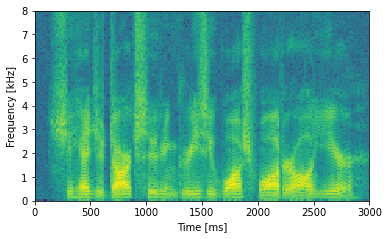

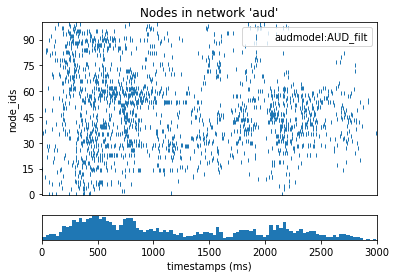

In [4]:
from bmtk.analyzer.spike_trains import plot_raster
from scipy import signal
from scipy.io import wavfile

fig, ax0 = plt.subplots(1, 1, figsize = (6,3.5), sharex=True)

sample_rate, samples = wavfile.read('sim_aud/audio/sa1.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

ax0.pcolormesh(times*1000, frequencies/1000, np.log(spectrogram))
ax0.set_ylabel('Frequency [kHz]')
ax0.set_xlabel('Time [ms]')
ax0.set_xlim((0,3000))

figr = plot_raster(config_file='sim_aud/config.json', group_by='model_template')
figr.set_figwidth(6)